In [12]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
DOGS_CAT_DIR = "./dogs-cats-mini"

filenames = os.listdir(DOGS_CAT_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,dog.4408.jpg,1
1,dog.2268.jpg,1
2,dog.2723.jpg,1
3,cat.1583.jpg,0
4,dog.3594.jpg,1


<Axes: xlabel='category'>

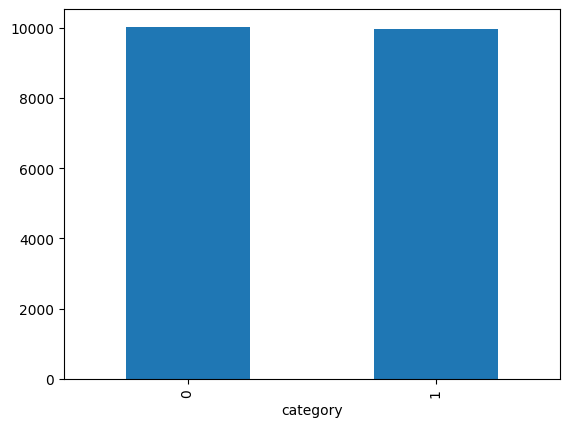

In [13]:
df['category'].value_counts().plot.bar()

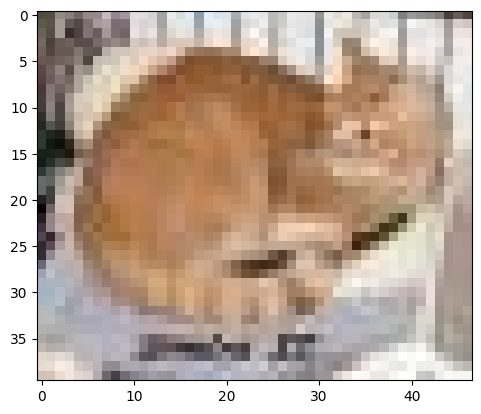

In [14]:
sample = random.choice(filenames)
image = load_img(DOGS_CAT_DIR+"/"+sample)
plt.imshow(image)

<Axes: xlabel='category'>

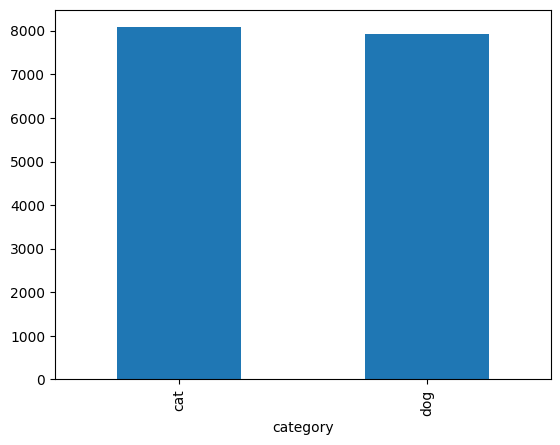

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001,
                                            mode='max')

callbacks = [earlystop, learning_rate_reduction]

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

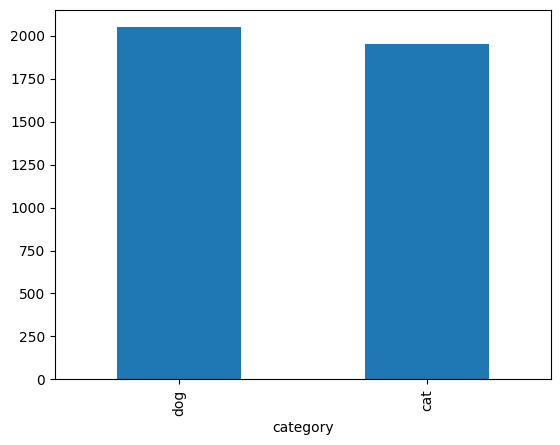

In [16]:
validate_df['category'].value_counts().plot.bar()

In [17]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15
# --- Update Generators ---
# Note: We remove rescale=1./255 and use preprocessing_function instead

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Specific for MobileNetV2
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Validation data must also use the same preprocessing
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Re-create generators (Batch size and directories remain the same)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    DOGS_CAT_DIR + "/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    DOGS_CAT_DIR + "/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [18]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    DOGS_CAT_DIR + "/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

# 1. Define the Input shape
input_tensor = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

# 2. Load the Base Model (MobileNetV2)
# include_top=False removes the final 1000-class classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

# 3. Freeze the base model
# We want to keep the pre-trained weights fixed
base_model.trainable = False

# 4. Build the new Head
x = base_model.output
x = GlobalAveragePooling2D()(x) # Flattens the output efficiently
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) # Prevents overfitting
output = Dense(2, activation='softmax')(x) # 2 classes: Dog/Cat

# 5. Combine Base and Head
transfer_model = Model(inputs=input_tensor, outputs=output)

# Compile
transfer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

transfer_model.summary()

/tmp/ipykernel_83345/1248337835.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the 

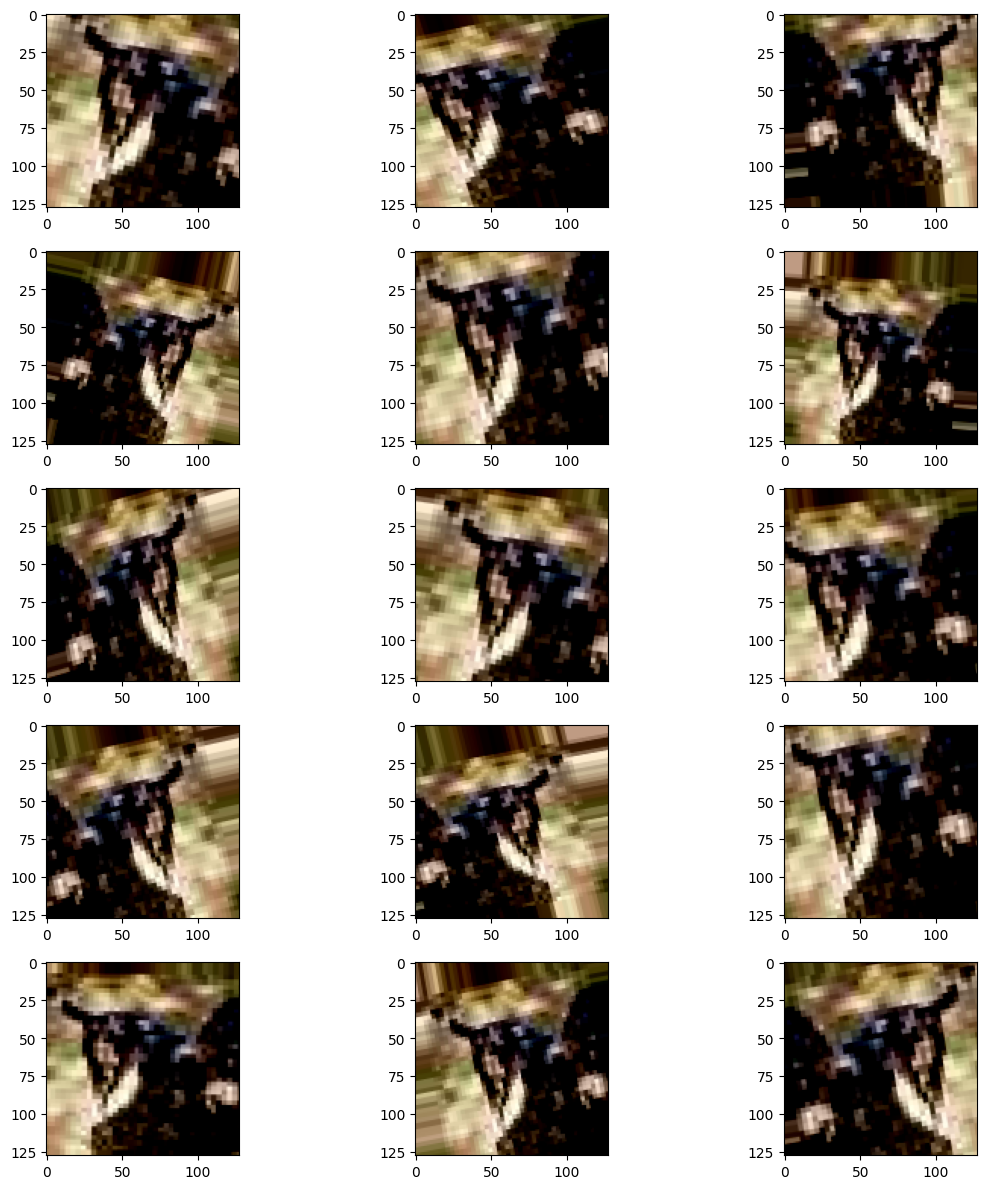

In [20]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [21]:

epochs=15
callbacks = [earlystop, learning_rate_reduction]
steps_per_epoch = int(np.ceil(total_train / batch_size))
validation_steps = int(np.ceil(total_validate / batch_size))

history_transfer = transfer_model.fit(
    train_generator, 
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks
)

Epoch 1/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 61s 55ms/step - accuracy: 0.7480 - loss: 0.5229 - val_accuracy: 0.7635 - val_loss: 0.4771 - learning_rate: 0.0010
Epoch 2/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - accuracy: 0.7837 - loss: 0.4551 - val_accuracy: 0.8070 - val_loss: 0.4104 - learning_rate: 0.0010
Epoch 3/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - accuracy: 0.7876 - loss: 0.4506 - val_accuracy: 0.8018 - val_loss: 0.4149 - learning_rate: 0.0010
Epoch 4/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7895 - loss: 0.4385
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - accuracy: 0.7911 - loss: 0.4416 - val_accuracy: 0.8052 - val_loss: 0.4082 - learning_rate: 0.0010
Epoch 5/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 63s 59ms/step - accuracy: 0.8036 - loss: 0.4209 - val_accuracy: 0.8112 - val_loss: 0.4027 - learning_rate: 5.0000e-04
Epoch 6/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - accu

In [22]:
transfer_model.save_weights("mobileNet.weights.h5")

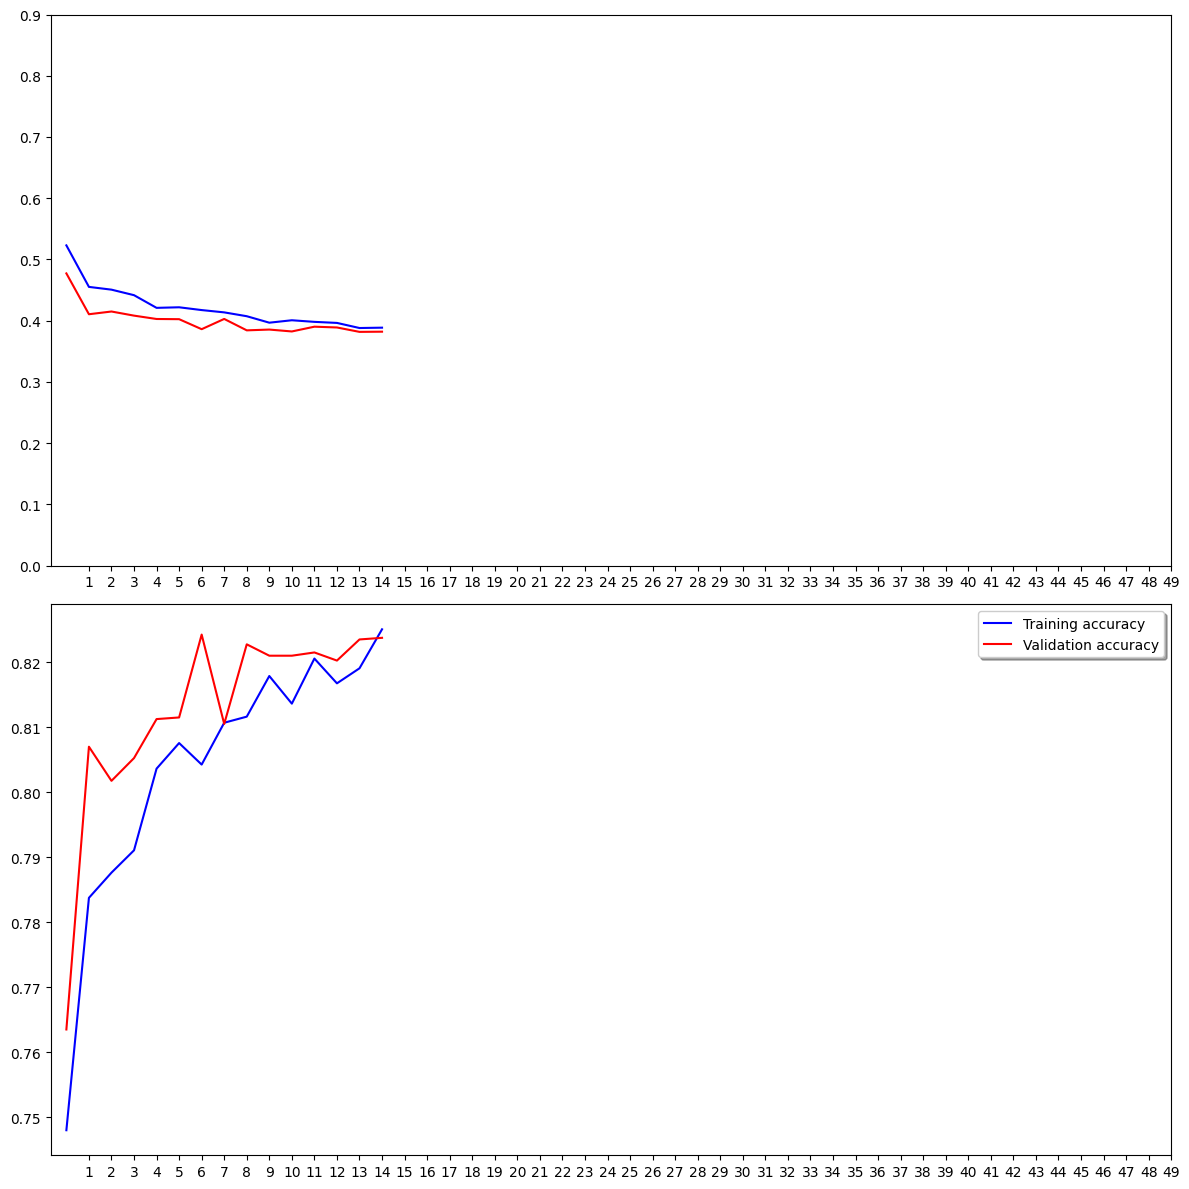

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history_transfer.history['loss'], color='b', label="Training loss")
ax1.plot(history_transfer.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history_transfer.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_transfer.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 50, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [25]:
test_filenames = os.listdir("./test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [26]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 5000 validated image filenames.


In [28]:
predict = transfer_model.predict(test_generator, steps=np.ceil(nb_samples/batch_size).astype(int))

334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step


/tmp/ipykernel_83345/3767708931.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })


<Axes: xlabel='category'>

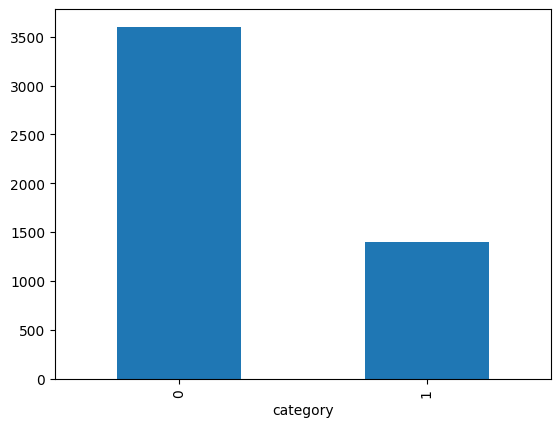

In [29]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })
test_df['category'].value_counts().plot.bar()

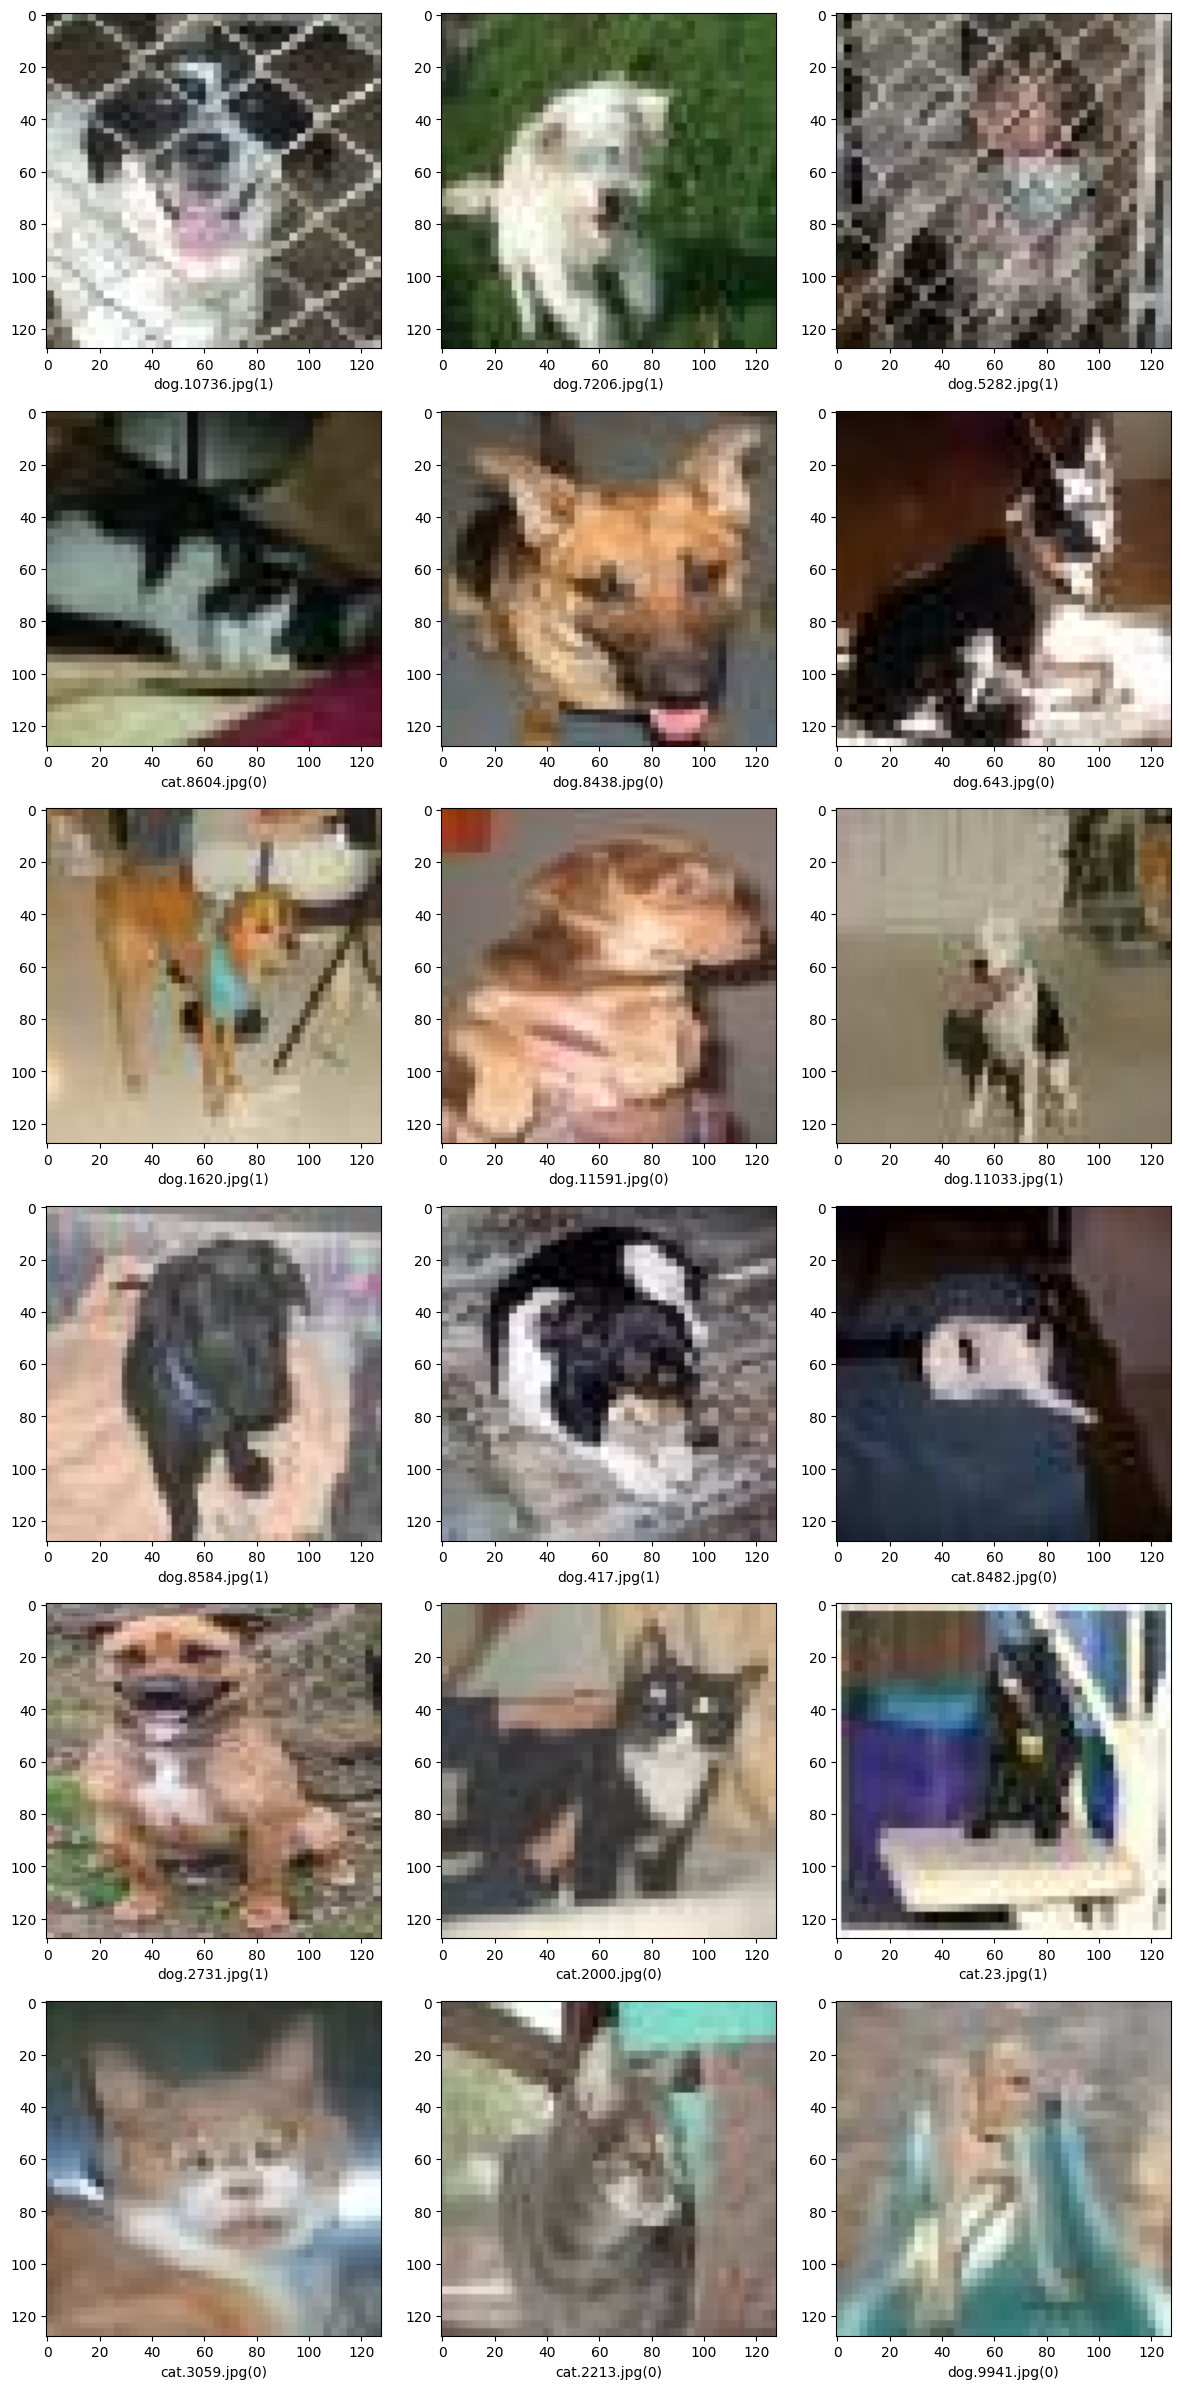

In [30]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [23]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [31]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Krok 1: Wyodrębnienie PRAWDZIWEJ etykiety ('cat' lub 'dog') z nazwy pliku
test_df['true_label'] = test_df['filename'].apply(
    lambda x: 'dog' if 'dog' in x else ('cat' if 'cat' in x else None)
)

# Krok 2: Konwersja PRAWDZIWEJ etykiety na postać numeryczną (0 lub 1), 
# aby pasowała do przewidzianych wyników
# Ustalenie mapowania: 'dog' -> 1, 'cat' -> 0
mapping = {'dog': 1, 'cat': 0}
test_df['true_numeric'] = test_df['true_label'].map(mapping)


# Krok 3: Ustawienie zmiennych
y_true = test_df['true_numeric']  # Prawdziwe etykiety (0 lub 1)
y_pred = test_df['category']      # Przewidziane etykiety (0 lub 1)

# Krok 4: Obliczenie Macierzy Błędu
labels = [0, 1]  # Etykiety: 0 (cat), 1 (dog)
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Konwersja do DataFrame dla lepszej wizualizacji
cm_df = pd.DataFrame(cm, index=['Prawda: CAT (0)', 'Prawda: DOG (1)'], columns=['Przewidziano: CAT (0)', 'Przewidziano: DOG (1)'])

print("Macierz Błędu (Confusion Matrix) dla 0 i 1:")
print(cm_df)

Macierz Błędu (Confusion Matrix) dla 0 i 1:
                 Przewidziano: CAT (0)  Przewidziano: DOG (1)
Prawda: CAT (0)                   2332                    138
Prawda: DOG (1)                   1269                   1261
